In [1]:
# Imports that we will need
from promis import ProMis, StaRMap
from promis.geo import PolarLocation, CartesianLocation, CartesianRasterBand, CartesianMap
from promis.loaders import OsmLoader
from promis.logic.spatial import Distance
from numpy import eye
from numpy.random import randint
import matplotlib.pyplot as plt

In [2]:
# We center a 1km^2 mission landscape over TU Darmstadt
tu_darmstadt = PolarLocation(latitude=49.878091, longitude=8.654052)
dimensions = (1000.0, 1000.0)
width, height = dimensions

# We load geographic features from OpenStreetMap using a range of filters
location_types = {
    "primary_road": "['highway' = 'primary']",
    "secondary_road": "['highway' = 'secondary']",
    "tertiary_road": "['highway' = 'tertiary']",
    "park": "['leisure' = 'park']",
    # ...
}
osm_loader = OsmLoader(tu_darmstadt, dimensions)
for name, osm_filter in location_types.items():
    osm_loader.load_routes(osm_filter, name)
    osm_loader.load_polygons(osm_filter, name)

# We now convert the data into an Uncertainty Annotated Map
uam = osm_loader.to_cartesian_map()

# We can add extra information, e.g., from background knowledge or other sensors
# Here, we place the drone operator at the center of the map
uam.features.append(CartesianLocation(0, 0, location_type="operator"))

# Annotate the same level of uncertainty on all features
uam.apply_covariance(10.0 * eye(2))

uam.save("tu_darmstadt_uam.pkl")

In [3]:
# Load a UAM
uam = CartesianMap.load("tu_darmstadt_uam.pkl")

# We create a statistical relational map (StaR Map) to represent the 
# stochastic relationships in the environment, computing a raster of 1000 x 1000 points
# using linear interpolation of a sample set
target_resolution = (250, 250)
target = CartesianRasterBand(tu_darmstadt, target_resolution, width, height)
star_map = StaRMap(target, uam, list(location_types.keys()) + ["operator"], "linear")

# The sample points for which the relations will be computed directly
support_resolution = (50, 50)
support = CartesianRasterBand(tu_darmstadt, support_resolution, width, height)

# We now compute the Distance and Over relationships for the selected points
# For this, we take 50 random samples from generated/possible map variations
star_map.add_support_points(support, 25)

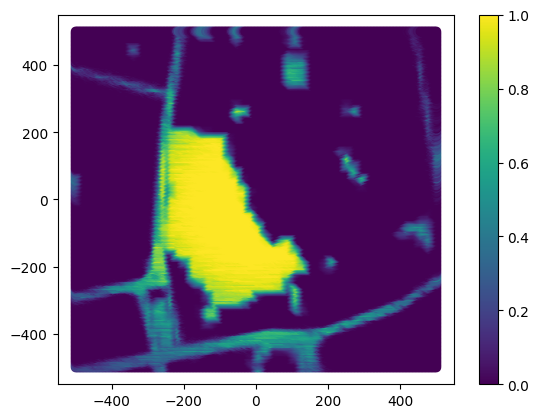

In [4]:
# In ProMis, we define the constraints of the mission 
# as hybrid probabilistic first-order logic program
logic = """
% Background knowledge and perception of drone
registered.
initial_charge ~ normal(90, 5).
discharge ~ normal(-0.1, 0.05).
weight ~ normal(2.0, 0.1).

% Weather according to forecast
1/10::fog; 9/10::clear.

% Visual line of sight
vlos(X) :- fog, distance(X, operator) < 500;
    clear, distance(X, operator) < 750.

% Simplified OPEN flight category
open(X) :- registered, vlos(X), weight < 25.

% Charge to return to the operator
can_return(X) :- B is initial_charge,
    O is discharge,
    D is distance(X, operator),
    0 < B + (2 * O * D).

% Permit to fly in parks and close to major roads
permit(X) :- over(X, park); 
    distance(X, primary_road) < 15;
    distance(X, secondary_road) < 10;
    distance(X, tertiary_road) < 5.

% The Probabilistic Mission Landscape
landscape(X) :- permit(X), open(X), can_return(X).
"""

# Solve mission constraints using StaRMap parameters and multiprocessing
promis = ProMis(star_map)
landscape = promis.solve(logic, n_jobs=4, batch_size=15)

# Show the resulting landscape
plt.colorbar(landscape.scatter())
plt.show()